In [38]:
#import necessary libraries

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from qutip import wigner, Qobj, displace, basis

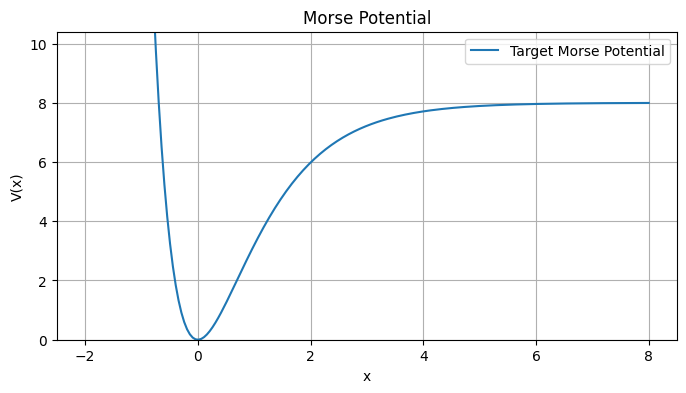

In [39]:
"""
Definining the Operators
- Morse Hamiltonian
- Always-on Hamiltonian
- Displacement Gate
- Qubit xy Rotation Gate
"""

# Parameters for Morse Time Evolution
time = 1
mass = 1
diss_energy = 8
width_param = 1
equib_length = 0

hbar = 1 # 6.62607015 * (10 ** (-34))

# Truncation for the oscillator Fock space
N = np.sqrt(2 * mass * diss_energy) / (width_param * hbar)
N = (int) (N - (1/2))

I_q = np.eye(2) #Identity operator for qubits
I_o = np.eye(N) #Identity operator for qumodes

a = np.diag(np.sqrt(np.arange(1, N)), 1)  # Annihilation operator
adag = a.T.conj()                         # Creation operator
n_op = adag @ a                           # Photon number operator

# Pauli Matrices for qubit
sigma_x = np.array([[0, 1], [1, 0]])
sigma_y = np.array([[0, -1j], [1j, 0]])
sigma_z = np.array([[1, 0], [0, -1]])

omega = 1.0  # Oscillator frequency
chi = 0.01   # Qubit-oscillator coupling

H_always_on = (chi * sigma_z + omega * np.eye(2))  # 2x2 matrix
H_always_on = np.kron(H_always_on, n_op)           # Full H'

# Always-on Time Evolution Gate
def H_On_Evo(t):
    return sp.linalg.expm(-1j * H_always_on * t)

#Dispacement gate 
def displacement(alpha):
    A = alpha * adag - np.conj(alpha) * a
    return sp.linalg.expm(A)

def D_full(alpha):
    return np.kron(I_q, displacement(alpha))

#Qubit XY Rotation Gate
def R_phi(theta, phi):
    op = (np.cos(phi) * sigma_x + np.sin(phi) * sigma_y)
    return sp.linalg.expm(-1j * theta / 2 * op)

def R_full(theta, phi):
    return np.kron(R_phi(theta, phi), I_o)


#Morse Hamiltonian
def H_Morse(u ,de, b, x0):
    """
    Morse Hamiltonian Gate

    Args:
        u (real): reduced mass of diatomic system
        de (real): dissociation energy
        b (real): width parameter
        x0 (real): equilibrium bond length

    Returns:
        csc_matrix: operator matrix
    """
    m_omega = np.sqrt(2 * de * (b ** 2) / u)
    X_op = (a + adag) / np.sqrt(2)
    P_op = 1j * (a - adag) / (np.sqrt(2))
    x_op = X_op * np.sqrt(hbar / (u * m_omega))
    p_op = P_op * np.sqrt(hbar * u * omega)

    kin_op = (p_op @ p_op) / (2 * u)

    exp_term = sp.linalg.expm(-1 * b * (x_op - x0 * np.eye(N)))
    mp_op = de * ((np.eye(N) - exp_term) @ (np.eye(N) - exp_term))

    full_m = kin_op + mp_op

    full_m = np.kron(I_q, full_m) #Embed into full qubit-oscillator hilbert space

    return full_m

def MH_Evo(t, u, de, b, x0):
    return sp.linalg.expm(-1j * H_Morse(u, de, b, x0) * t)

# Build the Gate Sequence

def gate_seq(params, d):
    """
    Builds the Gate Sequence

    Params: Each layer is a list of 4 parameters
    1. alpha_real - real part of alpha which shifts position
    2. alpha_imag - imaginary part of alpha which shifts momentum
    3. theta - one of the parameters for the xy qubit rotation gate
    4. phi - one of the parameters for the xy qubit rotaation gate
    
    """
    U = np.eye(2 * N, dtype=complex)
    for j in range(d):
        alpha_real = params[4*j]
        alpha_imag = params[4*j+1]
        theta = params[4*j+2]
        phi = params[4*j+3]
        
        D = D_full(alpha_real + 1j * alpha_imag)
        R = R_full(theta, phi)
        V = H_On_Evo(time)

        U = U @ V @ R @ D
    return U

# Define the Cost Function

# The cost function likely needs the most work


def fidelity_loss(params, d, U_target):
    U = gate_seq(params, d)
    dim = U.shape[0]
    fid = np.abs(np.trace(U.conj().T @ U_target))/ (dim)
    return 1 - fid

# Create an instance of the morse time evolution
morse_to_optimize = MH_Evo(t=time, u=mass, de=diss_energy, b=width_param, x0=equib_length)

#Plot the Morse Potential

# Position axis
x = np.linspace(-2, 8, 200)

# Morse potential
V_Target = diss_energy * (1 - np.exp(-width_param * (x - equib_length)))**2

# Plot
plt.figure(figsize=(8, 4))
plt.plot(x, V_Target, label='Target Morse Potential')
plt.xlabel('x')
plt.ylabel('V(x)')
plt.ylim(0, diss_energy * 1.3)  # Adjust the 1.2 factor as needed
plt.title('Morse Potential')
plt.grid(True)
plt.legend()
plt.show()

In [41]:
# Optimize

d = 1                                           # number of gate layers
num_params = d * 4                              # [Re(α), Im(α), θ, φ] per gate

# Provides small initial guess near 0
init_guess = np.random.rand(num_params) * 0.1   


result = sp.optimize.minimize(
    #optimize will make guesses for parameteres of fidelity_loss that minimize its return values
    fidelity_loss,          
    init_guess,
    args=(d, morse_to_optimize),
    method='BFGS',
    options={'disp': True}
)

optimal_params = result.x

# Print the Optimized Parameters

def print_optimal_params(params, d):
    print(f"Fock Space Truncation         = {N}")
    print()
    print("Oscillator Paremeters:")
    print(f"    oscillator frequency      = {omega}")
    print(f"    qubit-oscillator coupling = {chi}")
    print()
    print("Morse Parameters Used:")
    print(f"    hbar           = {hbar}")
    print(f"    time           = {time}")
    print(f"    mass           = {mass}")
    print(f"    diss_energy    = {diss_energy}")
    print(f"    width_param    = {width_param}")
    print(f"    equilib_length = {equib_length}")

    print()
    print("-" * 30)

    print("Optimized Paramters")
    for i in range(d):
        re_alpha = params[i * 4 + 0]
        im_alpha = params[i * 4 + 1]
        theta    = params[i * 4 + 2]
        phi      = params[i * 4 + 3]
        
        print(f"Gate {i+1}:")
        print(f"  α     = {re_alpha:.4f} + {im_alpha:.4f}j")
        print(f"  θ     = {theta:.4f}")
        print(f"  φ     = {phi:.4f}")
        print("-" * 30)

# After optimization
print_optimal_params(optimal_params, d)


Optimization terminated successfully.
         Current function value: 0.164113
         Iterations: 8
         Function evaluations: 45
         Gradient evaluations: 9
Fock Space Truncation         = 3

Oscillator Paremeters:
    oscillator frequency      = 1.0
    qubit-oscillator coupling = 0.01

Morse Parameters Used:
    hbar           = 1
    time           = 1
    mass           = 1
    diss_energy    = 8
    width_param    = 1
    equilib_length = 0

------------------------------
Optimized Paramters
Gate 1:
  α     = 0.3163 + -0.5790j
  θ     = 0.0000
  φ     = 0.0072
------------------------------


In [42]:
# Get the Exact Infidelity
infid = fidelity_loss(optimal_params, d, morse_to_optimize)
print(infid)

0.16411251991029474


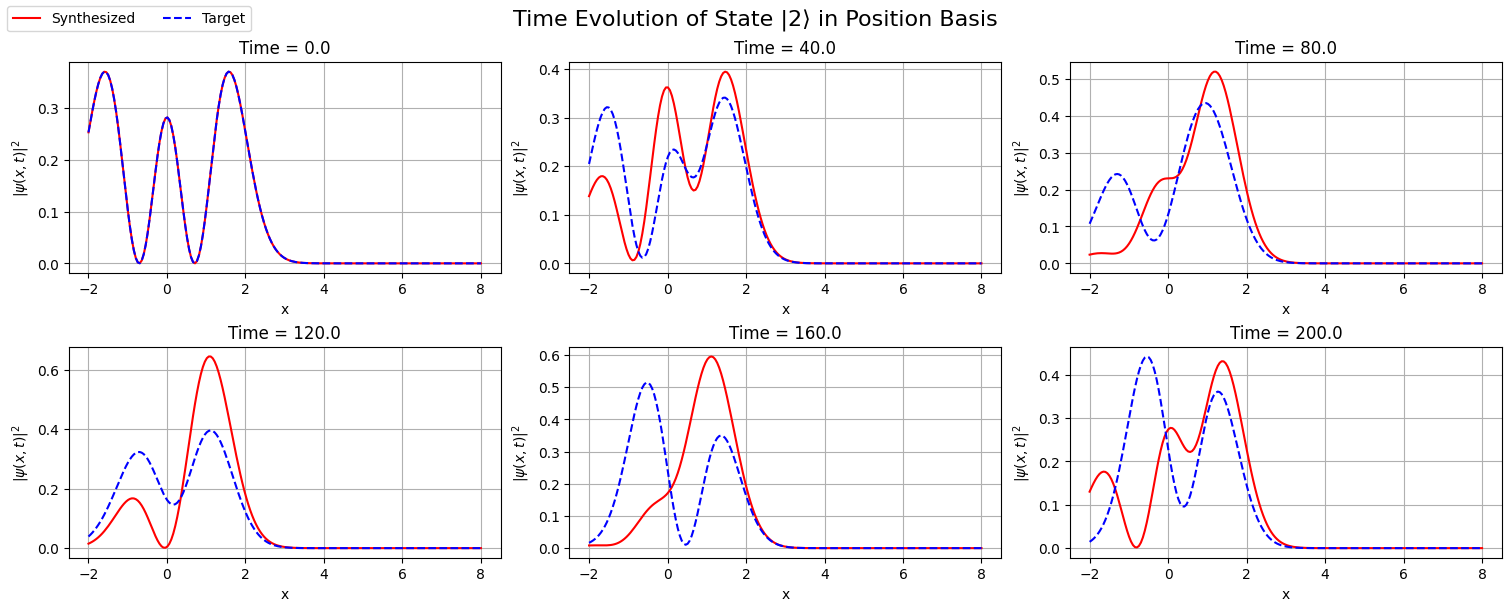

In [43]:
#Build the Unitary Generated
morse_generated = gate_seq(optimal_params, d)

def fock_basis_to_position(x, N, m=1.0, hbar=1.0, omega=1.0):
    """
    Returns T[i, n] = ⟨x_i | n⟩, i.e., harmonic oscillator wavefunction for n-th Fock state at position x_i
    """
    xi = np.sqrt(m * omega / hbar) * x
    prefactor = (m * omega / (np.pi * hbar))**0.25
    T = np.zeros((len(x), N), dtype=complex)

    for n in range(N):
        norm = 1 / np.sqrt(2**n * sp.special.factorial(n))
        Hn = sp.special.eval_hermite(n, xi)
        psi_n = prefactor * norm * np.exp(-0.5 * xi**2) * Hn
        T[:, n] = psi_n

    return T

# U is your unitary matrix, t is your evolution time
tgt_hamiltonian = (1j / time) * sp.linalg.logm(morse_to_optimize)
gen_hamiltonian = (1j / time) * sp.linalg.logm(morse_generated)

#target time
target_time = 200

#unitary for target time
time_target_unitary = sp.linalg.expm(-1j * tgt_hamiltonian * target_time)
time_generated_unitary = sp.linalg.expm(-1j * gen_hamiltonian * target_time)

# Parameters
n_var = morse_generated.shape[0]
x_var = np.linspace(-2, 8, 200)
topos = fock_basis_to_position(x_var, n_var)

# --- Choose Initial State ---
# Option 1: Fock state |n⟩
init_state_index = 2
init_state = np.zeros(n_var, dtype=complex)
init_state[init_state_index] = 1.0

# Option 2: Coherent state
# from qutip import coherent
# alpha = 1.0 + 0.5j
# init_state = coherent(n_var, alpha).full().flatten()

# --- Time Steps ---
n_steps = 6
times = np.linspace(0, target_time, n_steps)

# --- Setup plot grid ---
cols = 3
rows = (n_steps + cols - 1) // cols
fig, axes = plt.subplots(rows, cols, figsize=(5 * cols, 3 * rows), constrained_layout=True)
axes = axes.flatten()

# --- Loop through time evolution ---
for i, t in enumerate(times):
    ax = axes[i]

    # Evolve under synthesized
    U_gen_t = sp.linalg.expm(-1j * gen_hamiltonian * t)
    psi_gen_t = U_gen_t @ init_state
    psi_gen_x = topos @ psi_gen_t

    # Evolve under true
    U_tgt_t = sp.linalg.expm(-1j * tgt_hamiltonian * t)
    psi_tgt_t = U_tgt_t @ init_state
    psi_tgt_x = topos @ psi_tgt_t

    # Plot
    ax.plot(x_var, np.abs(psi_gen_x)**2, label='Synthesized', color='red')
    ax.plot(x_var, np.abs(psi_tgt_x)**2, label='Target', color='blue', linestyle='--')
    ax.set_title(f'Time = {round(t, 2)}')
    ax.set_xlabel('x')
    ax.set_ylabel(r'$|\psi(x,t)|^2$')
    ax.grid(True)

# Remove unused axes
for j in range(len(times), len(axes)):
    fig.delaxes(axes[j])

# Shared legend and title
handles, labels = axes[0].get_legend_handles_labels()
fig.legend(handles, labels, loc='upper left', ncol=2, fontsize='medium')
plt.suptitle(f'Time Evolution of State |{init_state_index}⟩ in Position Basis', fontsize=16)
plt.show()


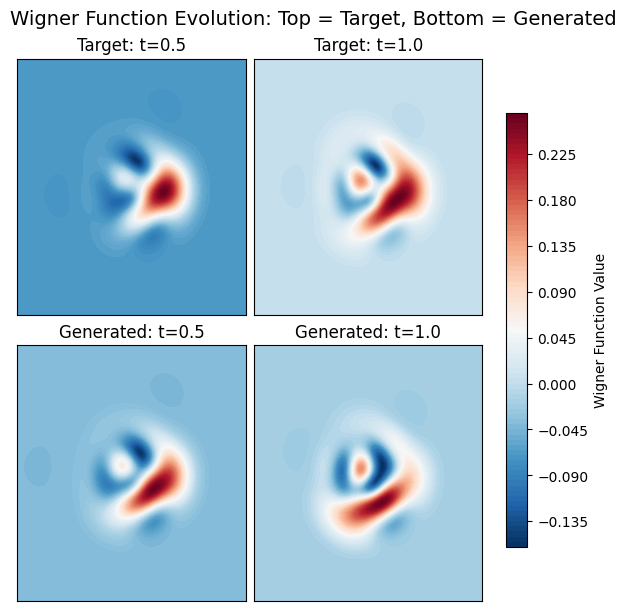

In [44]:
# See how wigner function evolves over time

# U is your unitary matrix, t is your evolution time
target_hamiltonian = (1j / time) * sp.linalg.logm(morse_to_optimize)
generated_hamiltonian = (1j / time) * sp.linalg.logm(morse_generated)

steps = 2
time_and_extra = time 
time_step = time_and_extra / steps

step_target_unitary = sp.linalg.expm(-1j * target_hamiltonian * time_step)
step_generated_unitary = sp.linalg.expm(-1j * generated_hamiltonian * time_step)

# Define phase space grid
xvec = np.linspace(-5, 5, 200)

#Function to create a coherent state
def coherent_state(alpha, N):
    """
    Returns the truncated coherent state |α⟩ in Fock basis of dimension N.
    """
    n = np.arange(N)
    state = (alpha ** n) / np.sqrt(sp.special.factorial(n))
    state *= np.exp(-0.5 * abs(alpha) ** 2)
    return state.astype(complex)

alfa = 1.0
init_matrix = coherent_state(alfa, n_var)

# Initial state:
fock_num = 5
#init_matrix = np.zeros(n_var, dtype=complex)
#init_matrix[fock_num] = 1.0  

# Apply synthesized unitary
step_state_generated = step_generated_unitary @ init_matrix

# Apply true unitary
step_state_target = step_target_unitary @ init_matrix

# Assume you already have `psi_t` in Fock basis (size N)
step_qobj_generated = Qobj(step_state_generated, dims=[n_var, [1]])
step_qobj_target = Qobj(step_state_target, dims=[n_var, [1]])

# Compute Wigner function
W_step_generated = wigner(step_qobj_generated, xvec, xvec)
W_step_target = wigner(step_qobj_target, xvec, xvec)

fig, axes = plt.subplots(2, steps, figsize=(3 * steps, 6), constrained_layout=True)
fig.suptitle('Wigner Function Evolution: Top = Target, Bottom = Generated', fontsize=14)

# Reset state
step_state_generated = step_generated_unitary @ init_matrix
step_state_target = step_target_unitary @ init_matrix

for i in range(steps):
    if i > 0:
        step_state_generated = step_generated_unitary @ step_state_generated
        step_state_target = step_target_unitary @ step_state_target

    # Convert to Qobj
    step_qobj_generated = Qobj(step_state_generated, dims=[n_var, [1]])
    step_qobj_target = Qobj(step_state_target, dims=[n_var, [1]])

    # Compute Wigner functions
    W_gen = wigner(step_qobj_generated, xvec, xvec)
    W_tar = wigner(step_qobj_target, xvec, xvec)

    # Top row: target
    ax_tar = axes[0, i]
    im1 = ax_tar.contourf(xvec, xvec, W_tar, 100, cmap='RdBu_r')
    ax_tar.set_title(f'Target: t={round((i+1)*time_step, 2)}')
    ax_tar.set_xticks([])
    ax_tar.set_yticks([])

    # Bottom row: generated
    ax_gen = axes[1, i]
    im2 = ax_gen.contourf(xvec, xvec, W_gen, 100, cmap='RdBu_r')
    ax_gen.set_title(f'Generated: t={round((i+1)*time_step, 2)}')
    ax_gen.set_xticks([])
    ax_gen.set_yticks([])

# Add single shared colorbar using a separate figure method
fig.colorbar(im1, ax=axes, location='right', shrink=0.8, label='Wigner Function Value')

plt.show()

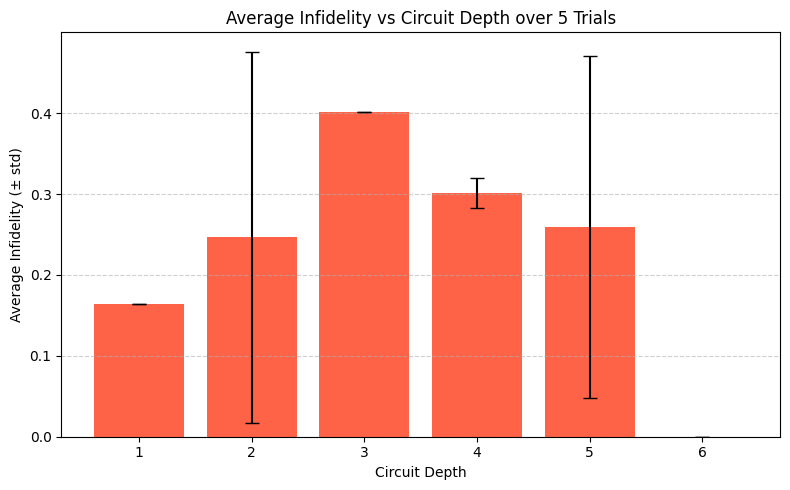

Depth 1: mean = 0.164113, std = 0.000000
Depth 2: mean = 0.246643, std = 0.229429
Depth 3: mean = 0.401064, std = 0.000000
Depth 4: mean = 0.301397, std = 0.018395
Depth 5: mean = 0.259128, std = 0.211561
Depth 6: mean = 0.000018, std = 0.000015


In [47]:
min_depth = 1
max_depth = 6
depths = [x for x in range(min_depth, max_depth + 1)]
infidelities_mean = []
infidelities_std = []

n_trials = 5  # Number of optimization runs per depth

for depth in depths:
    num_params = depth * 4
    trial_infid = []

    for trial in range(n_trials):
        init_guess = np.random.rand(num_params) * 0.1

        result = sp.optimize.minimize(
            fidelity_loss,
            init_guess,
            args=(depth, morse_to_optimize),
            method='BFGS',
            options={'disp': False}
        )

        params_optimized = result.x
        infid = fidelity_loss(params_optimized, depth, morse_to_optimize)
        trial_infid.append(infid)

    # Record average and std dev
    infidelities_mean.append(np.mean(trial_infid))
    infidelities_std.append(np.std(trial_infid))

# --- Plot with error bars ---
plt.figure(figsize=(8, 5))
plt.bar(depths, infidelities_mean, yerr=infidelities_std, capsize=5, color='tomato')
plt.xlabel('Circuit Depth')
plt.ylabel('Average Infidelity (± std)')
plt.title(f'Average Infidelity vs Circuit Depth over {n_trials} Trials')
plt.grid(axis='y', linestyle='--', alpha=0.6)
plt.tight_layout()
plt.show()

# Optional: print full data
for d, mean, std in zip(depths, infidelities_mean, infidelities_std):
    print(f"Depth {d}: mean = {mean:.6f}, std = {std:.6f}")